In [1]:
%%time
import os
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

CPU times: total: 812 ms
Wall time: 21.8 s


In [130]:
# Ruta de la carpeta que contiene los archivos
ruta_carpeta = 'data_files/'  # Reemplaza esto con la ruta de tu carpeta

# Lista para almacenar los DataFrames cargados
dataframes = []

# Recorre todos los archivos en la carpeta
for archivo in os.listdir(ruta_carpeta):
    # Verifica si el archivo tiene una extensión que corresponde a un archivo CSV o Excel
    if archivo.endswith('.csv') or archivo.endswith('.xlsx'):
        # Construye la ruta completa del archivo
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        #print("Cargando:", ruta_archivo)
        # Carga el archivo en un DataFrame y agrega a la lista (** hablar de la notación one line)
        df = pd.read_csv(ruta_archivo) if archivo.endswith('.csv') else pd.read_excel(ruta_archivo)
        #df.dropna(inplace=True)
        dataframes.append(df)
    
    #print(list(df.head(0).columns))
    #print(archivo,'\r\n',df.dtypes)
        
df_combinado = pd.concat(dataframes, ignore_index=True)
df_combinado.head(1)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"


In [131]:
def dropper(x):   
    x.dropna(inplace=True)
    return x

def clean_headers(x):   
    x = x.drop(x[x["Quantity Ordered"] == "Quantity Ordered"].index)
    return x

def formatear_fecha(df,col_name='Order Date'):
    df['fecha_objeto'] = pd.to_datetime(df[col_name], format="%m/%d/%y %H:%M")
    #df['date_fix'] = pd.to_datetime(df[col], format = "%m/%d/%y %H:%M")
    df['nueva_fecha'] = df['fecha_objeto'].dt.strftime("%d/%m/%Y")
    #df['nuevo_tiempo'] = df['fecha_objeto'].dt.strftime("%H:%M")
    df['time1'] = df['fecha_objeto'].dt.time
    df['nuevo_tiempo'] = pd.to_datetime(df['time1'], format = "%H:%M:%S")
    df.drop(columns=['time1'], inplace=True)
    #df.drop(columns=['fecha_objeto'], inplace=True)
    return df

def convertir_formato_fecha(fecha_hora_str,col_name='Order Date'):
    formato_entrada = "%m/%d/%y %H:%M"
    fecha_hora_obj = datetime.strptime(fecha_hora_str, formato_entrada)    
    formato_salida = "%d/%m/%Y %H:%M" 
    fecha_nueva_str = fecha_hora_obj.strftime(formato_salida)   
    return fecha_nueva_str

def separar(cadena_texto):
    lista_salida = cadena_texto.split()    
    return lista_salida

def split_address(df, colname="Purchase Address"):
    splitted_list = df[colname].str.split(",")
    df["City"] = pd.DataFrame(splitted_list)[colname].str.get(1)
    df["State"] = pd.DataFrame(splitted_list)[colname].str.get(2)
    df["State"] = df["State"].str.extract(r'(\w+)')
    return df

def replace_float(df,colname="Price Each"):
    df[colname] = df[colname].astype(float)
    return df
def extract_mm_yy(df, colname="fecha_objeto"):
    df["month"] = df[df['fecha_objeto'].dt.year]
df_combinado = df_combinado.pipe(dropper).pipe(clean_headers).pipe(formatear_fecha).pipe(split_address).pipe(replace_float)


In [132]:
agrupacion_mes = pd.DataFrame(df_combinado.groupby([df_combinado['fecha_objeto'].dt.year, df_combinado['fecha_objeto'].dt.month])['Price Each'].sum())

In [133]:
agrupacion_mes

Price Each
fecha_objeto fecha_objeto            
2019         1             1803264.98
             2             2188884.72
             3             2791207.83
             4             3367671.02
             5             3135125.13
             6             2562025.61
             7             2632539.56
             8             2230345.42
             9             2084992.09
             10            3715554.83
             11            3180600.68
             12            4588415.41
2020         1                8503.40

#### P: ¿Cuál fue el mejor año en ventas? ¿Cuánto se ganó ese año?

In [134]:
df_combinado['TotalSales']= pd.to_numeric(df_combinado['Quantity Ordered'], errors='coerce')*df_combinado['Price Each']
agrupacion_anho = pd.DataFrame(df_combinado.groupby([df_combinado['fecha_objeto'].dt.year])['TotalSales'].sum())
agrupacion_anho

,TotalSales
fecha_objeto,
2019,34483365.68
2020,8670.29


El mejor año de ventas fue 2019 y se ganó USD$34483365.68

#### P: ¿Cuál fue el mejor mes en ventas? ¿Cuánto se ganó ese mes?

In [135]:
agrupacion_mes = pd.DataFrame(df_combinado.groupby([df_combinado['fecha_objeto'].dt.year, df_combinado['fecha_objeto'].dt.month])['TotalSales'].sum().sort_values(ascending=False))
#agrupacion_mes = groupby([df_final['date'].dt.year, df_final['date'].dt.month])
#agrupacion_mes = df_combinado.groupby(df_combinado['fecha_objeto'].dt.strftime("%B"))["TotalSales"].sum().sort_values(ascending=False)
agrupacion_mes

TotalSales
fecha_objeto fecha_objeto            
2019         12            4613443.34
             10            3736726.88
             4             3390670.24
             11            3199603.20
             5             3152606.75
             3             2807100.38
             7             2647775.76
             6             2577802.26
             8             2244467.88
             2             2202022.42
             9             2097560.13
             1             1813586.44
2020         1                8670.29

In [ ]:
El mejor mes Diciembre de ventas fue Diciembre y se ganó USD$4613443.34

#### P: ¿Qué ciudad tuvo el mayor número de ventas?

In [136]:
df_combinado['Quantity Ordered'] = pd.to_numeric(df_combinado['Quantity Ordered'], errors='coerce')
agrupacion_ciudad = pd.DataFrame(df_combinado.groupby([df_combinado['City']])['Quantity Ordered'].sum().sort_values(ascending=False))
agrupacion_ciudad

,Quantity Ordered
City,
San Francisco,50239
Los Angeles,33289
New York City,27932
Boston,22528
Dallas,16730
Atlanta,16602
Seattle,16553
Portland,14053
Austin,11153


In [ ]:
La ciudad con mayor numero de ventas fue San Francisco con 50239 Ventas

#### P: ¿A qué hora deberíamos mostrar publicidad para maximizar la probabilidad de que los clientes compren el producto?

In [137]:
agrupacion_hora = pd.DataFrame(df_combinado.groupby([df_combinado['fecha_objeto'].dt.year,df_combinado['nuevo_tiempo'].dt.hour])['Quantity Ordered'].sum().sort_values(ascending=False))
agrupacion_hora

Quantity Ordered
fecha_objeto nuevo_tiempo                  
2019         19                       14470
             12                       14202
             11                       14005
             18                       13802
             20                       13768
             13                       13685
             14                       12362
             10                       12308
             21                       12244
             17                       12229
             16                       11662
             15                       11391
             22                        9899
             9                         9816
             23                        7065
             8                         7002
             7                         4556
             0                         4412
             6                         2810
             1                         2610
             5                         1491
             2                         1394
             4                          933
             3                          922
2020         0                           16
             1                            9
             3                            6
             2                            4
             4                            4
             5                            2

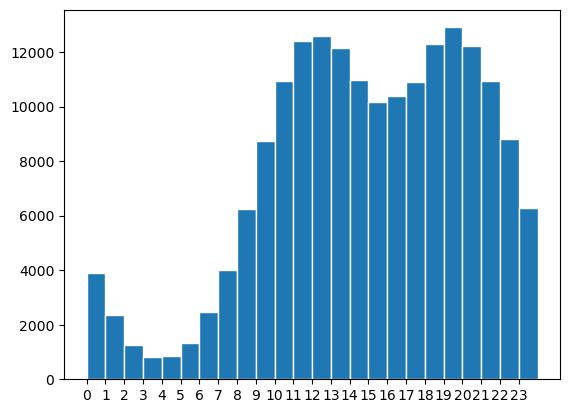

In [138]:
### GENERAR GRAFICA
df_combinado["Hours"] = df_combinado["nuevo_tiempo"].dt.hour

plt.hist(df_combinado["Hours"], bins=24, range=(0, 24), edgecolor='white')
plt.xticks(range(24))
plt.show()

In [ ]:
La hora en que se debe mostrar publicidad para maximizar ventas 18:00, pues el horario en que mas se vendió fue las 19:00. 
Adicionalmente, se podría considerar el horario de las 10:00 y las 11:00 pues tambien se vieron picos de ventas a las 11:00 y las 12:00

#### P: ¿Qué productos se venden más a menudo juntos?

In [170]:
df_combinado.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,fecha_objeto,nueva_fecha,nuevo_tiempo,City,State,TotalSales,Hours
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",2019-04-19 08:46:00,19/04/2019,1900-01-01 08:46:00,Dallas,TX,23.90,8
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",2019-04-07 22:30:00,07/04/2019,1900-01-01 22:30:00,Boston,MA,99.99,22
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",2019-04-12 14:38:00,12/04/2019,1900-01-01 14:38:00,Los Angeles,CA,600.00,14
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",2019-04-12 14:38:00,12/04/2019,1900-01-01 14:38:00,Los Angeles,CA,11.99,14
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",2019-04-30 09:27:00,30/04/2019,1900-01-01 09:27:00,Los Angeles,CA,11.99,9


In [168]:
def remove_lines_with_simple_comma(lst):
    return [line for line in lst in line.count(',') != 1]
agrupacion_pack = df_combinado.groupby(['Order ID'])['Product'].apply(tuple).reset_index()
#agrupacion_pack['conteos'] = 1
#agrupacion_pack.groupby(['Product'])['conteos'].sum().sort_values(ascending=False)
#df_combinado['Order ID'].value_counts()


0                             iPhone
1           Lightning Charging Cable
2                   Wired Headphones
3                   27in FHD Monitor
4                   Wired Headphones
                     ...            
178432      Lightning Charging Cable
178433         AA Batteries (4-pack)
178434               Vareebadd Phone
178435              Wired Headphones
178436    Bose SoundSport Headphones
Name: Product, Length: 185950, dtype: object

In [92]:
df_combinado[df_combinado['Order ID']=='160873']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,fecha_objeto,nueva_fecha,nuevo_tiempo,City,State,TotalSales,Hours
66347,160873,iPhone,1,700.00,02/10/19 10:24,"702 River St, San Francisco, CA 94016",2019-02-10 10:24:00,10/02/2019,1900-01-01 10:24:00,San Francisco,CA,700.00,10
66348,160873,Lightning Charging Cable,1,14.95,02/10/19 10:24,"702 River St, San Francisco, CA 94016",2019-02-10 10:24:00,10/02/2019,1900-01-01 10:24:00,San Francisco,CA,14.95,10
66349,160873,Apple Airpods Headphones,1,150.00,02/10/19 10:24,"702 River St, San Francisco, CA 94016",2019-02-10 10:24:00,10/02/2019,1900-01-01 10:24:00,San Francisco,CA,150.00,10
66350,160873,Wired Headphones,1,11.99,02/10/19 10:24,"702 River St, San Francisco, CA 94016",2019-02-10 10:24:00,10/02/2019,1900-01-01 10:24:00,San Francisco,CA,11.99,10
66351,160873,Google Phone,1,600.00,02/10/19 10:24,"702 River St, San Francisco, CA 94016",2019-02-10 10:24:00,10/02/2019,1900-01-01 10:24:00,San Francisco,CA,600.00,10


In [90]:
conteo_orders = df_combinado["Order ID"].value_counts()
max_repeticiones = conteo_orders.max()
ordenes_mas_repetidas = conteo_orders[conteo_orders == max_repeticiones].index.tolist()
filas_mas_repetidas = df_combinado[df_combinado["Order ID"].isin(ordenes_mas_repetidas)]

print("Grupos más repetidos:")
print(ordenes_mas_repetidas)

print("\nFilas correspondientes a los grupos más repetidos:")
print(ordenes_mas_repetidas)

Grupos más repetidos:
['160873']

Filas correspondientes a los grupos más repetidos:
['160873']


#### P: ¿Qué producto se vendió más? ¿Por qué crees que se vendió más?

In [103]:
agrupacion_prdct = pd.DataFrame(df_combinado.groupby(['Product','Price Each'])['Quantity Ordered'].sum().sort_values(ascending=False))
agrupacion_prdct.head()

,,Quantity Ordered
Product,Price Each,
AAA Batteries (4-pack),2.99,31017
AA Batteries (4-pack),3.84,27635
USB-C Charging Cable,11.95,23975
Lightning Charging Cable,14.95,23217
Wired Headphones,11.99,20557


In [ ]:
El producto que mas se vendió fue AAA Batteries (4-pack) (31017) y puede estar relacionado con el precio (USD$2.99)